# Kapitel 7: Neuronale Netzwerke

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
colors = 'bwr'#['b','y','r']
CMAP = colors#plt.cm.rainbow

In [5]:
from distutils.version import StrictVersion

In [6]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.18.1


In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.2.1


In [8]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.0')

Using TensorFlow backend.


2.0.6


In [9]:
# Evtl. hat Azure not 0.19, wir brauchen aber .20 fÃ¼r das Plotting, dann das hier installieren und Notebook neu starten
# !conda update pandas -y

In [10]:
import pandas as pd
print(pd.__version__)

assert StrictVersion(pd.__version__) >= StrictVersion('0.20.0')

0.20.1


## Laden und Vorbereiten der Bild-Daten

In [11]:
# !curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
# from zipfile import ZipFile
# zip = ZipFile(r'speed-limit-signs.zip')
# zip.extractall('.')

In [12]:
!ls -l speed-limit-signs

total 28
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 0
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 1
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 2
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 3
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 4
drwxrwxr-x 2 ubuntu ubuntu 4096 Jul 21 16:58 5
-rw-rw-r-- 1 ubuntu ubuntu  380 Jul 21 16:58 README.md


In [13]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [14]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [15]:
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

In [16]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

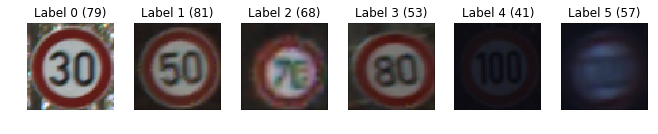

In [17]:
display_images_and_labels(images, labels)
# plt.savefig('ML_0708_signs.png', bbox_inches='tight')

## Modell-Architektur

In [18]:
y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [19]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [20]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
__________

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Zuerst testen wir unser Modell, ob wir es Ã¼berhaupt trainiert bekommen, indem wir auf einer kleinen Menge von Daten overfitten

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [23]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [24]:
!rm -r tf_log

# https://keras.io/callbacks/#tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log
# open http://localhost:6006

In [25]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3, callbacks=[tb_callback])

Train on 25 samples, validate on 12 samples
Epoch 1/100
25/25 [==============================] - 2s - loss: 1.8015 - acc: 0.1600 - val_loss: 1.7961 - val_acc: 0.0833
Epoch 2/100
25/25 [==============================] - 0s - loss: 1.6998 - acc: 0.2800 - val_loss: 2.7327 - val_acc: 0.0833
Epoch 3/100
25/25 [==============================] - 0s - loss: 2.0434 - acc: 0.2800 - val_loss: 1.8052 - val_acc: 0.0833
Epoch 4/100
25/25 [==============================] - 0s - loss: 1.6222 - acc: 0.2800 - val_loss: 1.7728 - val_acc: 0.1667
Epoch 5/100
25/25 [==============================] - 0s - loss: 1.7120 - acc: 0.2000 - val_loss: 1.7737 - val_acc: 0.1667
Epoch 6/100
25/25 [==============================] - 0s - loss: 1.7389 - acc: 0.2800 - val_loss: 1.7750 - val_acc: 0.1667
Epoch 7/100
25/25 [==============================] - 0s - loss: 1.7402 - acc: 0.3200 - val_loss: 1.7755 - val_acc: 0.1667
Epoch 8/100
25/25 [==============================] - 0s - loss: 1.7237 - acc: 0.3200 - val_loss: 1.780

25/25 [==============================] - 0s - loss: 0.0092 - acc: 1.0000 - val_loss: 5.6651 - val_acc: 0.4167
Epoch 68/100
25/25 [==============================] - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 6.0235 - val_acc: 0.4167
Epoch 69/100
25/25 [==============================] - 0s - loss: 0.0094 - acc: 1.0000 - val_loss: 6.0489 - val_acc: 0.4167
Epoch 70/100
25/25 [==============================] - 0s - loss: 0.0015 - acc: 1.0000 - val_loss: 6.1180 - val_acc: 0.4167
Epoch 71/100
25/25 [==============================] - 0s - loss: 9.1085e-04 - acc: 1.0000 - val_loss: 6.2126 - val_acc: 0.4167
Epoch 72/100
25/25 [==============================] - 0s - loss: 7.1135e-04 - acc: 1.0000 - val_loss: 6.3258 - val_acc: 0.4167
Epoch 73/100
25/25 [==============================] - 0s - loss: 8.1837e-04 - acc: 1.0000 - val_loss: 6.4468 - val_acc: 0.4167
Epoch 74/100
25/25 [==============================] - 0s - loss: 0.0018 - acc: 1.0000 - val_loss: 6.5450 - val_acc: 0.4167
Epoch 75/100
25/2

## Das sieht gut aus, nun versuchen wir es mit dem kompletten Datensatz ohne Overfitting und mit Dropout

In [26]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [27]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)

In [31]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('./model-checkpoints/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5');

In [32]:
!rm -r tf_log

In [33]:
# Depends on harware GPU architecture, set as high as possible (this works well on K80)
BATCH_SIZE = 500
%time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback, early_stopping_callback])
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

Train on 242 samples, validate on 61 samples
Epoch 1/500
242/242 [==============================] - 4s - loss: 1.8126 - acc: 0.1694 - val_loss: 1.7475 - val_acc: 0.0984
Epoch 2/500
242/242 [==============================] - 0s - loss: 1.7690 - acc: 0.1901 - val_loss: 1.7740 - val_acc: 0.2787
Epoch 3/500
242/242 [==============================] - 0s - loss: 1.7210 - acc: 0.2231 - val_loss: 1.7738 - val_acc: 0.2787
Epoch 4/500
242/242 [==============================] - 0s - loss: 1.7263 - acc: 0.2231 - val_loss: 1.7531 - val_acc: 0.2787
Epoch 5/500
242/242 [==============================] - 0s - loss: 1.6934 - acc: 0.2107 - val_loss: 1.7150 - val_acc: 0.0984
Epoch 6/500
242/242 [==============================] - 0s - loss: 1.7203 - acc: 0.2479 - val_loss: 1.7510 - val_acc: 0.0984
Epoch 7/500
242/242 [==============================] - 0s - loss: 1.6697 - acc: 0.2107 - val_loss: 1.7712 - val_acc: 0.1639
Epoch 8/500
242/242 [==============================] - 0s - loss: 1.6771 - acc: 0.2438 

242/242 [==============================] - 0s - loss: 1.2738 - acc: 0.4959 - val_loss: 1.4975 - val_acc: 0.3279
Epoch 67/500
242/242 [==============================] - 0s - loss: 1.3116 - acc: 0.4628 - val_loss: 1.4821 - val_acc: 0.3770
Epoch 68/500
242/242 [==============================] - 0s - loss: 1.2283 - acc: 0.4545 - val_loss: 1.5102 - val_acc: 0.4262
Epoch 69/500
242/242 [==============================] - 0s - loss: 1.2301 - acc: 0.4793 - val_loss: 1.4957 - val_acc: 0.3934
Epoch 70/500
242/242 [==============================] - 0s - loss: 1.2118 - acc: 0.4752 - val_loss: 1.5322 - val_acc: 0.3934
Epoch 71/500
242/242 [==============================] - 0s - loss: 1.1741 - acc: 0.5000 - val_loss: 1.7237 - val_acc: 0.3607
Epoch 72/500
242/242 [==============================] - 0s - loss: 1.1652 - acc: 0.4959 - val_loss: 1.5959 - val_acc: 0.3770
Epoch 73/500
242/242 [==============================] - 0s - loss: 1.1816 - acc: 0.5000 - val_loss: 1.4226 - val_acc: 0.4754
Epoch 74/500


242/242 [==============================] - 0s - loss: 0.4412 - acc: 0.8306 - val_loss: 1.3680 - val_acc: 0.6885
Epoch 132/500
242/242 [==============================] - 0s - loss: 0.5531 - acc: 0.7851 - val_loss: 1.4300 - val_acc: 0.6393
Epoch 133/500
242/242 [==============================] - 0s - loss: 0.4345 - acc: 0.8223 - val_loss: 1.6772 - val_acc: 0.6557
Epoch 134/500
242/242 [==============================] - 0s - loss: 0.4644 - acc: 0.8306 - val_loss: 1.6996 - val_acc: 0.6721
Epoch 135/500
242/242 [==============================] - 0s - loss: 0.4204 - acc: 0.8554 - val_loss: 1.5322 - val_acc: 0.7377
Epoch 136/500
242/242 [==============================] - 0s - loss: 0.3568 - acc: 0.8843 - val_loss: 1.4076 - val_acc: 0.7377
Epoch 137/500
242/242 [==============================] - 0s - loss: 0.3444 - acc: 0.9050 - val_loss: 1.2927 - val_acc: 0.7541
Epoch 138/500
242/242 [==============================] - 0s - loss: 0.3142 - acc: 0.8967 - val_loss: 1.2457 - val_acc: 0.7705
Epoch 

242/242 [==============================] - 0s - loss: 0.0398 - acc: 0.9876 - val_loss: 0.7731 - val_acc: 0.8197
Epoch 197/500
242/242 [==============================] - 0s - loss: 0.1177 - acc: 0.9587 - val_loss: 0.7678 - val_acc: 0.8033
Epoch 198/500
242/242 [==============================] - 0s - loss: 0.1003 - acc: 0.9711 - val_loss: 0.8633 - val_acc: 0.7869
Epoch 199/500
242/242 [==============================] - 0s - loss: 0.0801 - acc: 0.9793 - val_loss: 1.0812 - val_acc: 0.8361
Epoch 200/500
242/242 [==============================] - 0s - loss: 0.0293 - acc: 0.9917 - val_loss: 1.2686 - val_acc: 0.8197
Epoch 201/500
242/242 [==============================] - 0s - loss: 0.0735 - acc: 0.9793 - val_loss: 0.9542 - val_acc: 0.8361
Epoch 202/500
242/242 [==============================] - 0s - loss: 0.0365 - acc: 0.9876 - val_loss: 0.6818 - val_acc: 0.8361
Epoch 203/500
242/242 [==============================] - 0s - loss: 0.0302 - acc: 0.9876 - val_loss: 0.5692 - val_acc: 0.9016
Epoch 

242/242 [==============================] - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.7379 - val_acc: 0.8852
Epoch 262/500
242/242 [==============================] - 0s - loss: 0.0278 - acc: 0.9959 - val_loss: 0.6857 - val_acc: 0.8852
Epoch 263/500
242/242 [==============================] - 0s - loss: 0.0158 - acc: 0.9917 - val_loss: 0.6131 - val_acc: 0.9016
Epoch 264/500
242/242 [==============================] - 0s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.5559 - val_acc: 0.9016
Epoch 265/500
242/242 [==============================] - 0s - loss: 0.0479 - acc: 0.9876 - val_loss: 0.5209 - val_acc: 0.9016
Epoch 266/500
242/242 [==============================] - 0s - loss: 0.0095 - acc: 1.0000 - val_loss: 0.5387 - val_acc: 0.9016
Epoch 267/500
242/242 [==============================] - 0s - loss: 0.0469 - acc: 0.9835 - val_loss: 0.5591 - val_acc: 0.9016
Epoch 268/500
242/242 [==============================] - 0s - loss: 0.0223 - acc: 0.9959 - val_loss: 0.6422 - val_acc: 0.8852
Epoch 

242/242 [==============================] - 0s - loss: 0.0368 - acc: 0.9876 - val_loss: 0.5363 - val_acc: 0.9016
Epoch 327/500
242/242 [==============================] - 0s - loss: 0.0242 - acc: 0.9959 - val_loss: 0.5717 - val_acc: 0.8852
Epoch 328/500
242/242 [==============================] - 0s - loss: 0.0392 - acc: 0.9876 - val_loss: 0.5758 - val_acc: 0.8852
Epoch 329/500
242/242 [==============================] - 0s - loss: 0.0154 - acc: 1.0000 - val_loss: 0.5705 - val_acc: 0.8852
Epoch 330/500
242/242 [==============================] - 0s - loss: 0.0256 - acc: 0.9917 - val_loss: 0.5425 - val_acc: 0.8852
Epoch 331/500
242/242 [==============================] - 0s - loss: 0.0778 - acc: 0.9793 - val_loss: 0.4708 - val_acc: 0.8852
Epoch 332/500
242/242 [==============================] - 0s - loss: 0.0315 - acc: 0.9876 - val_loss: 0.4026 - val_acc: 0.9016
Epoch 333/500
242/242 [==============================] - 0s - loss: 0.0821 - acc: 0.9835 - val_loss: 0.3664 - val_acc: 0.8852
Epoch 

242/242 [==============================] - 0s - loss: 0.0209 - acc: 0.9876 - val_loss: 0.4373 - val_acc: 0.8852
Epoch 392/500
242/242 [==============================] - 0s - loss: 0.0297 - acc: 0.9917 - val_loss: 0.4381 - val_acc: 0.9016
Epoch 393/500
242/242 [==============================] - 0s - loss: 0.0157 - acc: 0.9959 - val_loss: 0.4323 - val_acc: 0.9180
Epoch 394/500
242/242 [==============================] - 0s - loss: 0.0124 - acc: 0.9917 - val_loss: 0.4370 - val_acc: 0.9180
Epoch 395/500
242/242 [==============================] - 0s - loss: 0.0124 - acc: 0.9959 - val_loss: 0.4466 - val_acc: 0.9180
Epoch 396/500
242/242 [==============================] - 0s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.4553 - val_acc: 0.9180
Epoch 397/500
242/242 [==============================] - 0s - loss: 0.0162 - acc: 0.9917 - val_loss: 0.4617 - val_acc: 0.9180
Epoch 398/500
242/242 [==============================] - 0s - loss: 0.0117 - acc: 1.0000 - val_loss: 0.4592 - val_acc: 0.9180
Epoch 

242/242 [==============================] - 0s - loss: 0.0051 - acc: 1.0000 - val_loss: 0.4469 - val_acc: 0.9180
Epoch 457/500
242/242 [==============================] - 0s - loss: 0.0090 - acc: 0.9917 - val_loss: 0.4305 - val_acc: 0.9344
Epoch 458/500
242/242 [==============================] - 0s - loss: 0.0040 - acc: 1.0000 - val_loss: 0.4206 - val_acc: 0.9344
Epoch 459/500
242/242 [==============================] - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4184 - val_acc: 0.9344
Epoch 460/500
242/242 [==============================] - 0s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.4307 - val_acc: 0.9344
Epoch 461/500
242/242 [==============================] - 0s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.4573 - val_acc: 0.9344
Epoch 462/500
242/242 [==============================] - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.4822 - val_acc: 0.9344
Epoch 463/500
242/242 [==============================] - 0s - loss: 0.0212 - acc: 0.9917 - val_loss: 0.5352 - val_acc: 0.9344
Epoch 

# Bewertung

In [34]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 2s


(0.047735791653394699, 0.99339938163757324)

In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 0s


(0.064851462841033936, 0.97368419170379639)

# Sichern des Modells

In [36]:
!rm -r models
!mkdir models

In [37]:
model.save('models/conv-vgg.hdf5')

In [38]:
!ls -lh models

total 55M
-rw-rw-r-- 1 ubuntu ubuntu 55M Aug  9 07:12 conv-vgg.hdf5


In [39]:
!curl --upload-file ./models/conv-vgg.hdf5 https://transfer.sh/conv-vgg.hdf5

https://transfer.sh/8XV70/conv-vgg.hdf5

# Ausprobieren auf ein paar Test-Daten

In [40]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 1, 5, 3, 4, 0, 1, 3, 0, 1])

In [41]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

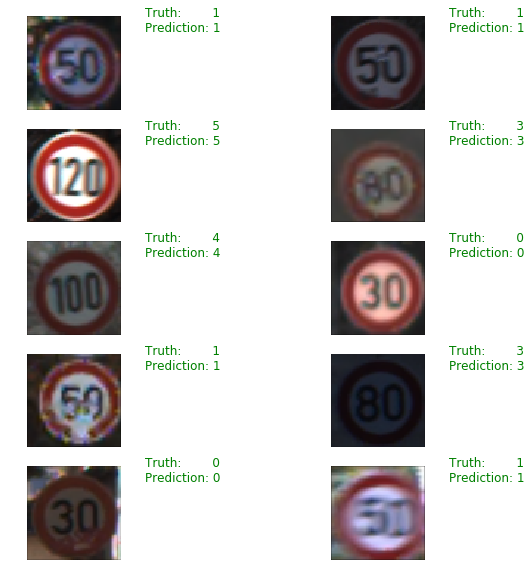

In [42]:
display_prediction(sample_images, ground_truth, predicted_categories)